<a href="https://colab.research.google.com/github/dpanagop/data_analytics_examples/blob/master/online_retail/Online_retail_Segmentation_by_RFM_Country.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentaion of online retail customers
## Part II - Segmentation by Recency, Frequency, Monetary Vavlue (RFM) and Country.

## Introduction
In this notebook we perform customer segmantation of online retail customers based on their spending per product categories. The dataset used is [Online Retail II Data Set](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II) from UC Irvine Machine Learning Repository. Countries' GDP is from Wikipedia's article [List of countries by GDP (nominal)](https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)). 

## Loading libraries and fetching data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,MiniBatchKMeans, AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder
from scipy.cluster.hierarchy import dendrogram
from wordcloud import WordCloud
sns.set_style("whitegrid")

In [2]:
!wget archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx
!wget github.com/dpanagop/data_analytics_examples/raw/master/online_retail/GDP.xlsx

--2021-01-13 04:42:49--  http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45622278 (44M) [application/x-httpd-php]
Saving to: ‘online_retail_II.xlsx’

online_retail_II.xl 100%[===================>]  43.51M  27.2MB/s    in 1.6s    

2021-01-13 04:42:51 (27.2 MB/s) - ‘online_retail_II.xlsx’ saved [45622278/45622278]

--2021-01-13 04:42:51--  http://github.com/dpanagop/data_analytics_examples/raw/master/online_retail/GDP.xlsx
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/dpanagop/data_analytics_examples/raw/master/online_retail/GDP.xlsx [following]
--2021-01-13 04:42:51--  https://g

In [3]:
online_retail=pd.read_excel('online_retail_II.xlsx',sheet_name=None)
online_retail = online_retail['Year 2009-2010'].append(online_retail['Year 2010-2011'],ignore_index=True)

Let's take a glimpse of the dataset

In [4]:
print(online_retail.shape)
online_retail.head()

(1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
# number of unique customers
print('Number of unique customers: {}'.format(len(online_retail['Customer ID'].unique())))

Number of unique customers: 5943


In [6]:
# examine countries
print('Number of unique countries: {}\n'.format(len(online_retail['Country'].unique())))
online_retail['Country'].value_counts()

Number of unique countries: 43



United Kingdom          981330
EIRE                     17866
Germany                  17624
France                   14330
Netherlands               5140
Spain                     3811
Switzerland               3189
Belgium                   3123
Portugal                  2620
Australia                 1913
Channel Islands           1664
Italy                     1534
Norway                    1455
Sweden                    1364
Cyprus                    1176
Finland                   1049
Austria                    938
Denmark                    817
Unspecified                756
Greece                     663
Japan                      582
Poland                     535
USA                        535
United Arab Emirates       500
Israel                     371
Hong Kong                  364
Singapore                  346
Malta                      299
Iceland                    253
Canada                     228
Lithuania                  189
RSA                        169
Bahrain 

Some customers appera with two countries in their invoices.

In [7]:
customer_countries=online_retail.groupby(['Customer ID']).agg({'Country':'nunique'})
customer_countries['Country'].value_counts()

1    5929
2      13
Name: Country, dtype: int64

Min and max Invoice Dates are

In [8]:
online_retail['date']= pd.to_datetime(online_retail['InvoiceDate'])
print (online_retail['date'].min())
print (online_retail['date'].max())
max_date=online_retail['date'].max()

2009-12-01 07:45:00
2011-12-09 12:50:00


## Recency, Frequency, Monetary Vavlue (RFM)
This section calculates Recency, Frequency, Monetary Vavlue (RFM) for each customer.

For each customer:
* **Recency** is the number of days from last InvoiceDate to most current InvoiceDate of the dataset (2011-12-09),
* **Frequency** is the number of days from first InvoiceDate to last  InvoiceDate divided by the number of invoices,
* **Monetary value** is the average cost where cost is the product of Quantity by Price.

In [9]:
online_retail['cost']=online_retail['Quantity']*online_retail['Price']
online_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,date,cost
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01 07:45:00,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01 07:45:00,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01 07:45:00,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12-01 07:45:00,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12-01 07:45:00,30.0


In [10]:
customer_rfm=online_retail.groupby(['Customer ID']).agg({'Invoice':'nunique', 
                                                         'cost':'sum',
                                                         'date':['min','max']})
customer_rfm.columns=['count','total_cost','min_date','max_date']
customer_rfm.head()

,count,total_cost,min_date,max_date
Customer ID,,,,
12346.0,17,-64.68,2009-12-14 08:34:00,2011-01-18 10:17:00
12347.0,8,5633.32,2010-10-31 14:20:00,2011-12-07 15:52:00
12348.0,5,2019.40,2010-09-27 14:59:00,2011-09-25 13:13:00
12349.0,5,4404.54,2009-12-04 12:49:00,2011-11-21 09:51:00
12350.0,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00


In [11]:
customer_rfm['recency']=max_date-customer_rfm['max_date']
customer_rfm['recency'] = customer_rfm['recency'].dt.days
customer_rfm['days']=max_date-customer_rfm['min_date']
customer_rfm['days'] = customer_rfm['days'].dt.days
customer_rfm['frequency']=customer_rfm['days']/customer_rfm['count']
customer_rfm['monetary_value']=customer_rfm['total_cost']/customer_rfm['count']
customer_rfm=customer_rfm.drop(['count','total_cost','days','min_date','max_date'],axis=1)
customer_rfm.head()

,recency,frequency,monetary_value
Customer ID,,,
12346.0,325,42.647059,-3.804706
12347.0,1,50.375000,704.165000
12348.0,74,87.400000,403.880000
12349.0,18,147.000000,880.908000
12350.0,309,309.000000,334.400000


## Countries
This section appends to each customer his/hers country GDP. For customers with more than on countries, we take the weighted by number of invoices GDP.

In [12]:
customer_countries=online_retail.groupby(['Customer ID','Country']).agg({'Invoice':'nunique'})
customer_countries.head()

,,Invoice
Customer ID,Country,
12346.0,United Kingdom,17
12347.0,Iceland,8
12348.0,Finland,5
12349.0,Italy,5
12350.0,Norway,1


In [13]:
countries_GDP=pd.read_excel('GDP.xlsx')
countries_GDP.head()

,Country,GDP
0,United Kingdom,2638296
1,EIRE,399064
2,Germany,3780553
3,France,2551451
4,Netherlands,886339


In [14]:
customer_countries=customer_countries.reset_index().merge(countries_GDP,on='Country',how='left').set_index('Customer ID')
customer_countries.head()

,Country,Invoice,GDP
Customer ID,,,
12346.0,United Kingdom,17,2638296.0
12347.0,Iceland,8,20805.0
12348.0,Finland,5,267856.0
12349.0,Italy,5,1848222.0
12350.0,Norway,1,366386.0


For some customers we do not have country/GDP.

In [15]:
print('Customers with missing GDP data: {}'.format(customer_countries['GDP'].isna().sum()))
customer_countries[customer_countries['GDP'].isna()]

Customers with missing GDP data: 23


,Country,Invoice,GDP
Customer ID,,,
12351.0,Unspecified,1,NaN
12363.0,Unspecified,2,NaN
12470.0,Unspecified,1,NaN
12743.0,Unspecified,2,NaN
14265.0,Unspecified,4,NaN
14442.0,Channel Islands,12,NaN
14564.0,Channel Islands,5,NaN
14566.0,Channel Islands,4,NaN
14568.0,Channel Islands,2,NaN


Next, we calculate the weighted GDP.

In [16]:
customer_countries['weight']=customer_countries['Invoice']*customer_countries['GDP']
customer_countries=customer_countries.groupby(['Customer ID']).agg({'Invoice':'sum',
                                                               'weight':'sum'})
customer_countries['weighted GDP']=customer_countries['weight']/customer_countries['Invoice']
customer_countries.head()

,Invoice,weight,weighted GDP
Customer ID,,,
12346.0,17,44851032.0,2638296.0
12347.0,8,166440.0,20805.0
12348.0,5,1339280.0,267856.0
12349.0,5,9241110.0,1848222.0
12350.0,1,366386.0,366386.0


##Customer Segmentation based on RFM - Country GDP
In this section we perform customer segmentation based on RFM-GDP. We use k-Means and hierarchical clustering.

### Join RFM - Country GDP
First, we join RFM and GDP data. The result will be the input to clustering algorithms.


In [17]:
customer_RFM_GDP=pd.merge(customer_rfm,customer_countries,on='Customer ID')
customer_RFM_GDP=customer_RFM_GDP.drop(['Invoice','weight'],axis=1)
customer_RFM_GDP.head()

,recency,frequency,monetary_value,weighted GDP
Customer ID,,,,
12346.0,325,42.647059,-3.804706,2638296.0
12347.0,1,50.375000,704.165000,20805.0
12348.0,74,87.400000,403.880000,267856.0
12349.0,18,147.000000,880.908000,1848222.0
12350.0,309,309.000000,334.400000,366386.0


Check for NAs

In [18]:
customer_RFM_GDP[customer_RFM_GDP.isnull().any(axis=1)]

,recency,frequency,monetary_value,weighted GDP
Customer ID,,,,


### Customer clustering
This is the section with the actual customer clustering.

#### k-Means
We scale the input matrix and use the elbow method to decide the number of customer clusters.

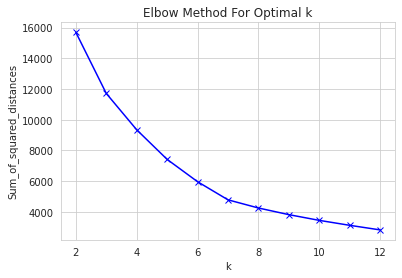

In [19]:
scaler = StandardScaler()
X_std = scaler.fit_transform(customer_RFM_GDP)
Sum_of_squared_distances = []
K = range(2,13)
for k in K:
    km = KMeans(n_clusters=k, max_iter=5000, n_init=500, random_state=100,n_jobs= -1) 
    km = km.fit(X_std)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

First, we select 3 as the number of clusters.

In [20]:
# set number of clusters
true_k = 3
# perform k-means clustering 
model = KMeans(n_clusters=true_k, max_iter=5000, n_init=500, random_state=100,n_jobs= -1) 
model.fit(X_std)
# append cluster assignment for each item set
customer_RFM_GDP['cluster']=model.labels_
# print number of items per cluster
print(customer_RFM_GDP['cluster'].value_counts())

0    4225
1    1708
2       9
Name: cluster, dtype: int64


Function cluster_profile_RFM_country will be used to profile clusters. There is a cut off parameter that can be used to exclude from the profilling clusters with small cardinality.

In [21]:
def cluster_profile_RFM_country(customer_clustering,cut_off=0):
  ''' profile clusters '''

  customer_clusters=customer_clustering.reset_index().groupby(['cluster']).agg({'Customer ID':['count'], 
                                                         'recency':'median',
                                                         'frequency':'median',
                                                         'monetary_value':'median',
                                                         'weighted GDP':'median'})
  idx= customer_clusters['Customer ID']>=cut_off
  idx=idx['count'].to_list()
  customer_clusters=customer_clusters[idx]
  print(customer_clusters)
  print('\n')
  customer_clusters_sum=customer_clusters.sum(axis=0)
  #print(customer_clusters_sum)
  customer_clusters['monetary_value']=100*customer_clusters['monetary_value']/customer_clusters_sum['monetary_value']
  customer_clusters['frequency']=100*customer_clusters['frequency']/customer_clusters_sum['frequency']
  customer_clusters['recency']=100*customer_clusters['recency']/customer_clusters_sum['recency']
  customer_clusters['weighted GDP']=100*customer_clusters['weighted GDP']/customer_clusters_sum['weighted GDP']
  print(customer_clusters)
  print('\n')
  
  print('HEAT map')
  print('Numbers are column percentages')
  sns.heatmap(customer_clusters.drop(['Customer ID'],axis=1), annot=True,  linewidths=.5)


Examining the two clusters with more than 100 items, we see that:
* cluster 0 contains customers that shopped more recently than cluster 1 (customers in cluster 0 shopped 9 days ago while cluster 1 91 days ago),
* cluster 0 contains customers that bought less frequently than cluster 1 (customers in cluster 0 shop every 66 days while in cluster 1 every 364 days),
* cluster 0 contains customers with more monetary value than cluster (cluster 0 has a median of 243 for monetary value, while cluster 1 197)


        Customer ID recency   frequency monetary_value weighted GDP
              count  median      median         median       median
cluster                                                            
0              4225      45   65.545455         243.41    2638296.0
1              1708     463  364.000000         196.91    2638296.0


        Customer ID    recency  frequency monetary_value weighted GDP
              count     median     median         median       median
cluster                                                              
0              4225   8.858268  15.259259      55.280251         50.0
1              1708  91.141732  84.740741      44.719749         50.0


HEAT map
Numbers are column percentages


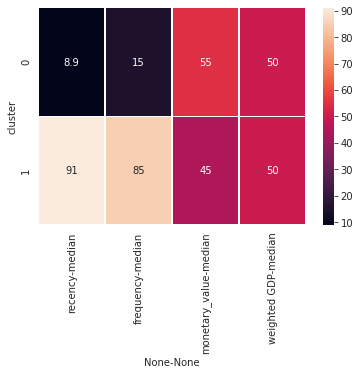

In [22]:
cluster_profile_RFM_country(customer_RFM_GDP,cut_off=100)

Selecting 7 as the number of clusters, we obtain 4 clusters with cardinality bigger than 100.

In [52]:
# set number of clusters
true_k = 7
# perform k-means clustering 
model = KMeans(n_clusters=true_k, max_iter=5000, n_init=500, random_state=100,n_jobs= -1) 
model.fit(X_std)
# append cluster assignment for each item set
customer_RFM_GDP['cluster']=model.labels_
# print number of items per cluster
print(customer_RFM_GDP['cluster'].value_counts())

2    3549
0    1547
4     572
5     247
6      17
1       9
3       1
Name: cluster, dtype: int64


Examining the two clusters with more than 100 items, we see that:
* clusters 2 and 5 contain more frequent customers, wich shop more frequently and their invoice have greter monetary vlaue,
* cluster 5 contains customers from countries with lower GDP than the rest of the clusters
* cluster 4 has the customers with the lowest RFM score.

        Customer ID recency   frequency monetary_value weighted GDP
              count  median      median         median       median
cluster                                                            
0              1547     389  227.333333     204.902500    2638296.0
2              3549      35   58.666667     243.840000    2638296.0
4               572     619  603.500000     166.050000    2638296.0
5               247      79   92.125000     393.990625     503416.0


        Customer ID    recency  frequency monetary_value weighted GDP
              count     median     median         median       median
cluster                                                              
0              1547  34.670232  23.158878      20.311848    31.339994
2              3549   3.119430   5.976485      24.171697    31.339994
4               572  55.169340  61.479689      16.460426    31.339994
5               247   7.040998   9.384948      39.056029     5.980017


HEAT map
Numbers are column pe

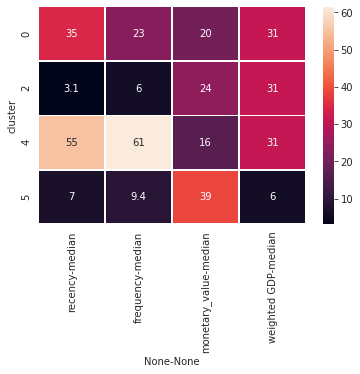

In [53]:
cluster_profile_RFM_country(customer_RFM_GDP,cut_off=100)

We store results of k-means clusterig with 7 clusters.

In [54]:
customer_RFM_GDP_k_Means=customer_RFM_GDP.copy()

#### Hierachical clustering
Using hierachical clustering we can gain a better understanding of the possible number of clusters.

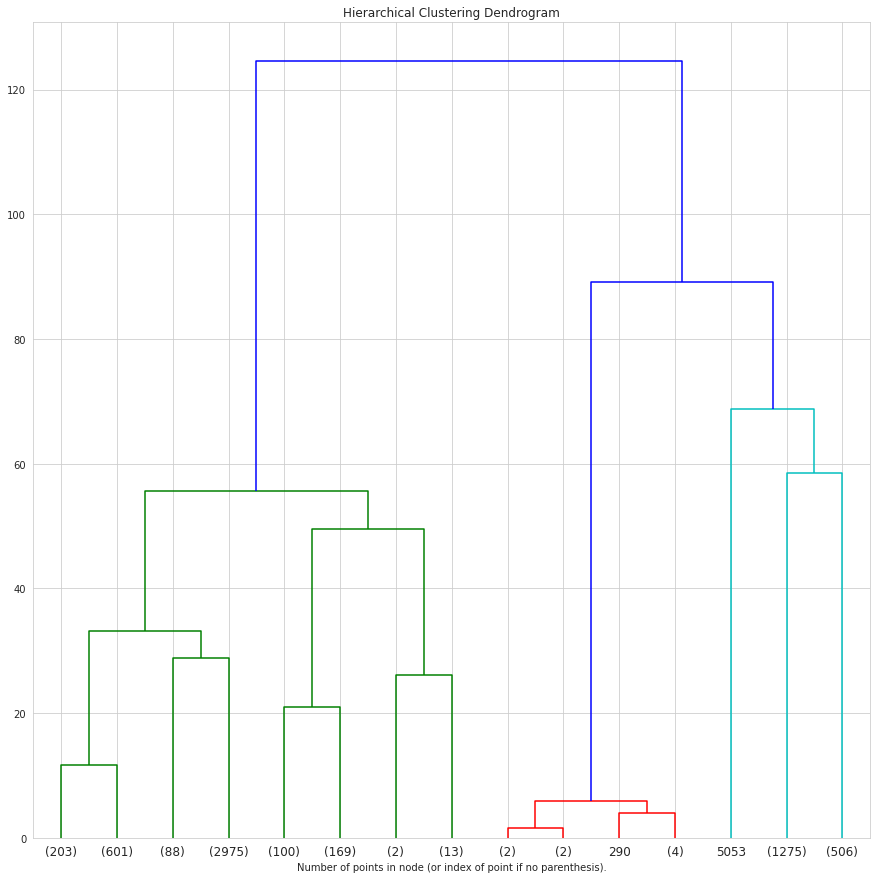

In [55]:
# source https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='ward')

model = model.fit(X_std)
plt.figure(figsize=(15,15))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Examining the two clustering solution of hierachical clustering, we see that we end up with clusters similiar to the two major clusters of our first k-means try. 

In [56]:
model = AgglomerativeClustering(n_clusters=2,linkage='ward')
model.fit(X_std)
# append cluster assignment for each item set
customer_RFM_GDP['cluster']=model.labels_
# print number of items per cluster
print(customer_RFM_GDP['cluster'].value_counts())

1    4151
0    1791
Name: cluster, dtype: int64


        Customer ID recency frequency monetary_value weighted GDP
              count  median    median         median       median
cluster                                                          
0              1791     446     336.5     196.016667    2638296.0
1              4151      43      64.0     244.800000    2638296.0


        Customer ID    recency  frequency monetary_value weighted GDP
              count     median     median         median       median
cluster                                                              
0              1791  91.206544  84.019975       44.46671         50.0
1              4151   8.793456  15.980025       55.53329         50.0


HEAT map
Numbers are column percentages


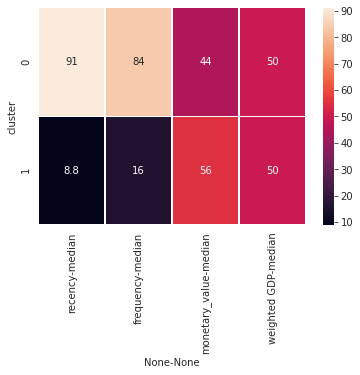

In [57]:
cluster_profile_RFM_country(customer_RFM_GDP,cut_off=100)

The same applies when we try with 7 clusters in hierachical clustering. The results are similar to k-means.

In [58]:
model = AgglomerativeClustering(n_clusters=7,linkage='ward')
model.fit(X_std)
# append cluster assignment for each item set
customer_RFM_GDP['cluster']=model.labels_
# print number of items per cluster
print(customer_RFM_GDP['cluster'].value_counts())
#cluster_profile_RFM_country(customer_RFM_GDP,cut_off=100)

0    3867
4    1275
1     506
6     269
2      15
5       9
3       1
Name: cluster, dtype: int64


We will store the results of k-means clustering into 7 clusters.

In [60]:
customer_RFM_GDP_k_Means.to_pickle('customer_segments_RFM_country.pickle')
# load with
# customer_spending_per_category = pd.read_pickle(file_name)

In [62]:
from google.colab import files
files.download('customer_segments_RFM_country.pickle') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>